<a href="https://colab.research.google.com/github/barauna-lo/Code_Library/blob/main/VAE_Dietzsch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJETO 03 - VAE** 
**GABRIEL DIETZSCH**

REQUISITOS:

- Selecionar 2 datasets (rotulados)

- Treinar modelos VAEs:

  ▸ Ajustar o melhor modelo (topologia) segundo a
função de custo (conjunto validação)

- Explorar o espaço latente:

  ▸Gerar gráficos com a projeção do espaço latente
em 2D (PCA)

  ▸Usar os rótulos na projeção

- Algumas questões:

  1. Há formação de clusters no espaço latente?

  2. Há separação dos rótulos no espaço latente?

  3. A projeção ilustra quanto da variância?

Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados (**REALIZADO AO LONGO DESTE NOTEBOOK**)

O presete código foi baseado em códigos disponíveis online e constante nas referências passadas em sala de aula. 

# Setup, Datasets, Classes e Funções

In [ ]:
#SETUP

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
DS1 = keras.datasets.mnist.load_data()
DS2 = keras.datasets.fashion_mnist.load_data()

In [ ]:
#Create a sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # z=u+Sigma Epsilon

In [ ]:
#VAE

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Kullback-Liebler Divergence  
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
#PROJEÇÃO DO ESPAÇO LATENTE

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    print("Projeção do Espaço Latente")
    plt.show()

In [ ]:
#CLUSTERIZAÇÃO DO ESPAÇO LATENTE

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    print("Clusters no Espaço Latente")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# **Dataset 1**

## Topologia 1

In [ ]:
#ENCODER

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=6, padding="same")(encoder_inputs)
#x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 5, 5, 32)     320         ['input_18[0][0]']               
                                                                                                  
 flatten_8 (Flatten)            (None, 800)          0           ['conv2d_15[0][0]']              
                                                                                                  
 dense_17 (Dense)               (None, 32)           25632       ['flatten_8[0][0]']              
                                                                                            

In [ ]:
#DECODER

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 32))(x)
#x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=4, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_18 (Dense)            (None, 1568)              4704      
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 28, 28, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 28, 28, 1)        289       
 Transpose)                                                      
                                                                 
Total params: 14,241
Trainable params: 14,241
Non-trainable

In [ ]:
#Treinamento VAE

(x_train, _), (x_test, _) = DS1 #keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=5, batch_size=128)

Epoch 1/5
547/547 [==============================] - 58s 94ms/step - loss: 285.0524 - reconstruction_loss: 222.2961 - kl_loss: 3.3526
Epoch 2/5
547/547 [==============================] - 54s 98ms/step - loss: 190.8865 - reconstruction_loss: 182.1969 - kl_loss: 3.4465
Epoch 3/5
547/547 [==============================] - 49s 89ms/step - loss: 177.2687 - reconstruction_loss: 171.8375 - kl_loss: 4.3187
Epoch 4/5
547/547 [==============================] - 54s 98ms/step - loss: 173.0673 - reconstruction_loss: 167.6427 - kl_loss: 4.5403
Epoch 5/5
547/547 [==============================] - 49s 90ms/step - loss: 170.0231 - reconstruction_loss: 164.6368 - kl_loss: 4.7244


Projeção do Espaço Latente


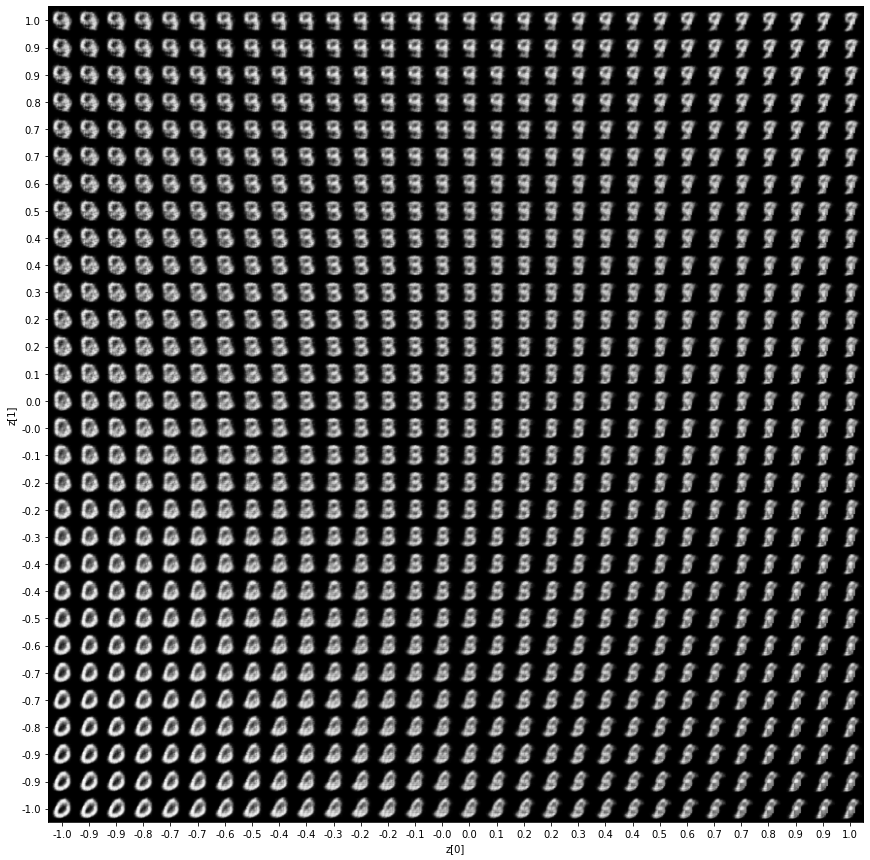

In [ ]:
plot_latent_space(vae)

Clusters no Espaço Latente


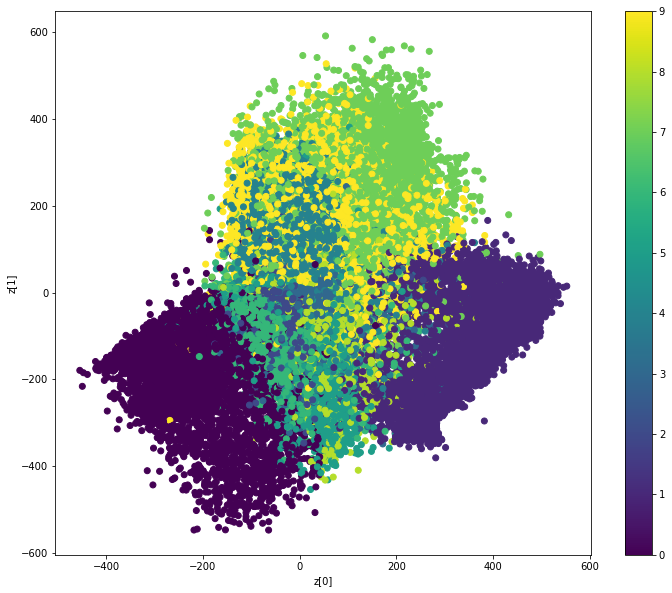

In [ ]:
plot_label_clusters(vae, x_train, y_train)


## Topologia 2

In [ ]:
#ENCODER

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#DECODER

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Treinamento VAE

(x_train, _), (x_test, _) = DS1 #keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=5, batch_size=128)

plot_latent_space(vae)

plot_label_clusters(vae, x_train, y_train)

NameError: ignored

## Topologia 3

In [ ]:
#ENCODER

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#DECODER

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Treinamento VAE

(x_train, _), (x_test, _) = DS1 #keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=5, batch_size=128)

plot_latent_space(vae)

plot_label_clusters(vae, x_train, y_train)

# **Dataset 2**

In [ ]:
#Train the VAE

(x_train, _), (x_test, _) = DS2 #keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=5, batch_size=128)

Epoch 1/5
547/547 [==============================] - 54s 96ms/step - loss: 362.6173 - reconstruction_loss: 316.5020 - kl_loss: 5.6423
Epoch 2/5
547/547 [==============================] - 51s 93ms/step - loss: 294.1174 - reconstruction_loss: 286.4117 - kl_loss: 5.9695
Epoch 3/5
547/547 [==============================] - 49s 89ms/step - loss: 287.0650 - reconstruction_loss: 280.5317 - kl_loss: 6.0705
Epoch 4/5
547/547 [==============================] - 49s 90ms/step - loss: 283.6678 - reconstruction_loss: 276.8274 - kl_loss: 6.1751
Epoch 5/5
547/547 [==============================] - 47s 87ms/step - loss: 281.5536 - reconstruction_loss: 274.5844 - kl_loss: 6.2423


Projeção do Espaço Latente


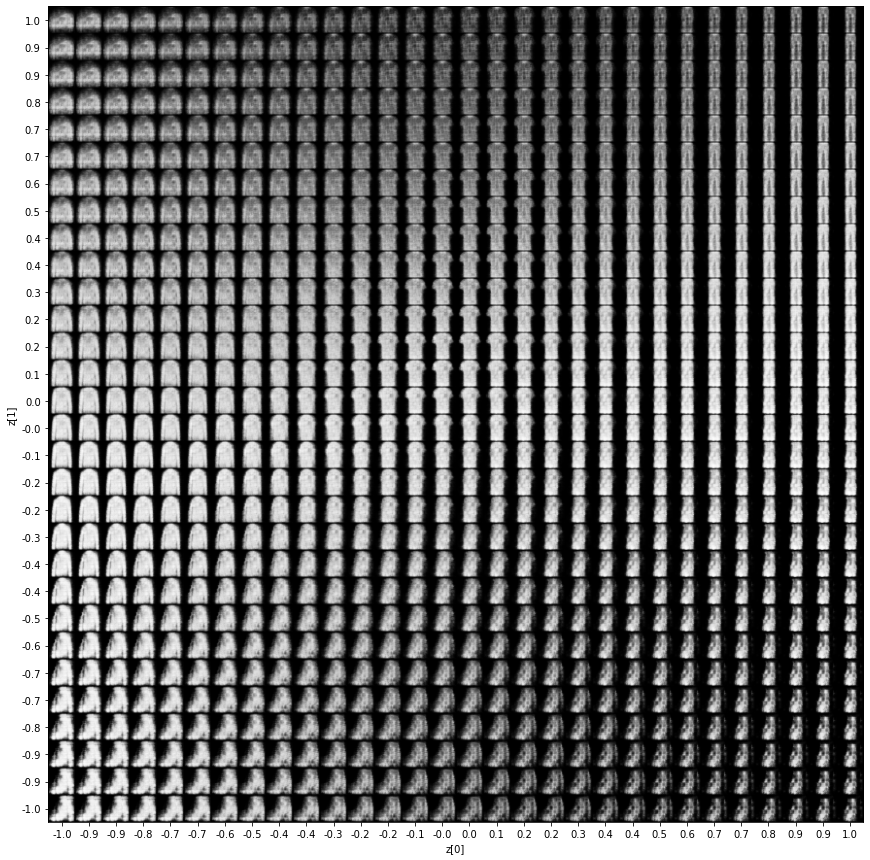

In [ ]:
plot_latent_space(vae)

Clusters no Espaço Latente


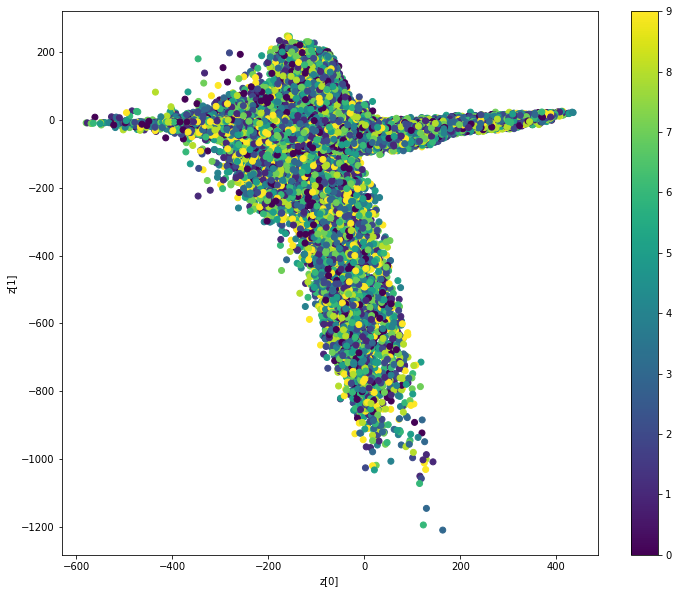

In [ ]:
plot_label_clusters(vae, x_train, y_train)